In [1]:
import os
import shutil
from collections import Counter
from timeit import default_timer as timer
%load_ext autoreload
%autoreload 2


# from PIL import Image
# import cv2

!pip install ipywidgets

import seaborn as sns
from matplotlib import pyplot as plt

from typing import List, Tuple
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import engine
import helper_functions


for filename in os.listdir('/kaggle/input'):
    print(filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


fungi-all


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchinfo import summary
import time

from tempfile import TemporaryDirectory

# cudnn.benchmark = True
# plt.ion() 
print(torch.__version__)

2.0.0


# Setup device agnostic code

In [3]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Merging test-train-valid directories

As we observed during data exploration the test and valid directories are not balanced although the train directory is. We decided to merge all the directories in one directory destination_dir = '/kaggle/working/all', perform cross-validation and evaluate the model using balanced accuracy.


In [4]:
# Define the directory path to check
directory_to_check = '/kaggle/input/fungi-all'

# Check if the directory exists
if not os.path.exists(directory_to_check):
    # Define the source and destination directories
    source_base_dir = '/kaggle/input/microscopic-fungi-images'
    destination_dir = '/kaggle/working/fungi-all'

    # List of subdirectories to merge
    subdirectories_to_merge = ['H1', 'H2', 'H3', 'H5', 'H6']

    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Loop through each of the train, test, and val directories
    for dataset_dir in ['train', 'test', 'valid']:
        # Loop through the subdirectories to merge
        for subdirectory in subdirectories_to_merge:
            # Define the source and destination paths
            source_path = os.path.join(source_base_dir, dataset_dir, subdirectory)
            destination_path = os.path.join(destination_dir, subdirectory)

            # Create a directory for the class if it doesn't exist
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)

            # Copy the files from source to destination
            for filename in os.listdir(source_path):
                source_file = os.path.join(source_path, filename)
                destination_file = os.path.join(destination_path, filename)
                shutil.copy(source_file, destination_file)

        # Define the directory path
        all_directory = '/kaggle/working/fungi-all'

    print("Files merged successfully.")
            
else:
        all_directory = '/kaggle/input/fungi-all'
        print("fungi-all exists")

            

fungi-all exists


In [5]:
# List of subdirectories to check
subdirectories_to_check = ['H1', 'H2', 'H3', 'H5', 'H6']

# Loop through the subdirectories
for subdirectory in subdirectories_to_check:
    subdirectory_path = os.path.join(all_directory, subdirectory)
    
    # Check if the directory exists
    if os.path.exists(subdirectory_path):
        # Count the number of files in the directory
        num_files = len(os.listdir(subdirectory_path))
        print(f"Number of files in '{subdirectory}': {num_files}")
    else:
        print(f"'{subdirectory}' directory does not exist in '{all_directory}'.")

Number of files in 'H1': 1874
Number of files in 'H2': 1465
Number of files in 'H3': 1163
Number of files in 'H5': 1160
Number of files in 'H6': 1139


## Load Data and Visualize them

In [6]:
DATA_DIR = all_directory

dataset = ImageFolder(DATA_DIR)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 6801
    Root location: /kaggle/input/fungi-all


In [7]:
labels = dataset.targets
dataset.class_to_idx

{'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}

### Visualize a few randomly selected images

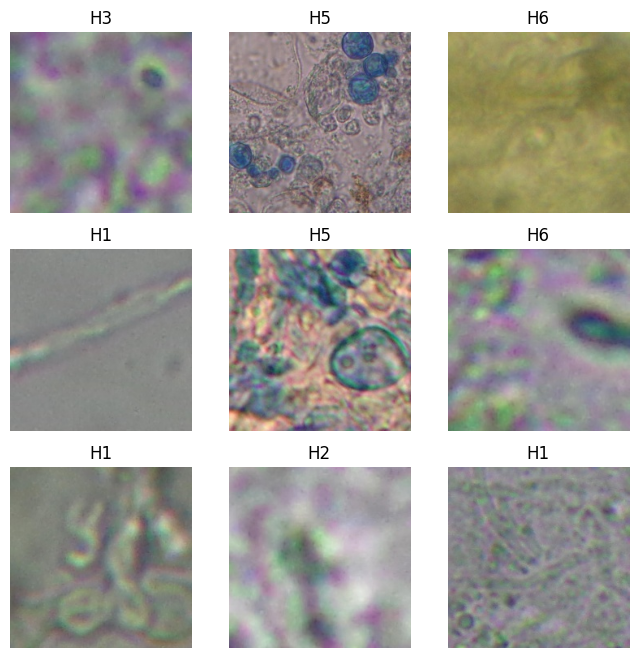

In [8]:
labels_map = {
    0: "H1",
    1: "H2",
    2: "H3",
    3: "H5",
    4: "H6",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item() # generate a random integer in the dataset range
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

### Plot the classes' distribution

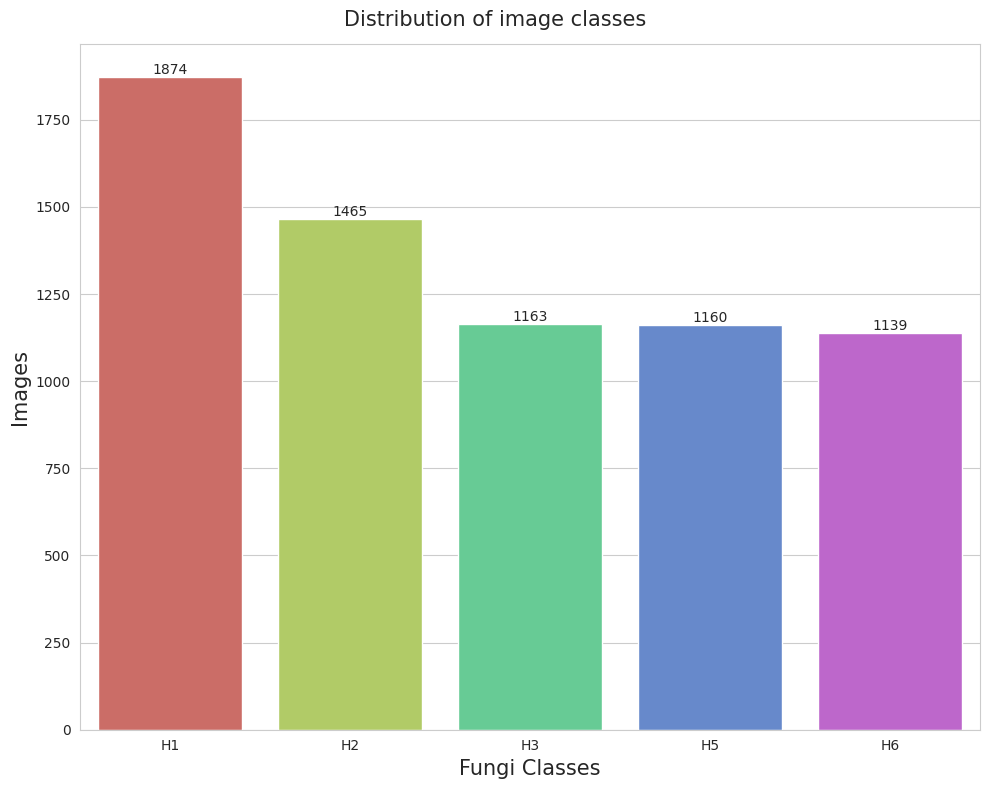

In [9]:
img_per_class = dict(Counter(dataset.targets))

plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(x=dataset.classes, y=[value for value in img_per_class.values()], color='blue', palette='hls')
ax.bar_label(ax.containers[0])

plt.xlabel('Fungi Classes', fontsize=15)
plt.ylabel(f'Images', fontsize=15)


plt.suptitle(f'Distribution of image classes', fontsize=15)
plt.savefig(f'/kaggle/working/classes_distribution.png')
plt.show()

 ## Split into stratified train,val, test subsets and store into folders (Kiriakos' function)

In [10]:
def split_dataset(dataset, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, val_ratio, and test_ratio should be 1.0")
        
    # initial split
    train_data, test_data, train_labels, test_labels = train_test_split(
        dataset, labels, test_size=test_ratio, random_state=random_seed, stratify=labels)
    remaining_ratio = val_ratio / (train_ratio + val_ratio)
    # rain-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size=remaining_ratio, random_state=random_seed, stratify=train_labels)
    
    return train_data, val_data, test_data

# Load pretrained EfficientNet and inspect

Load the EfficientNetb0 model available in torchvision and use the pretrained weights to do transfer learning. Reset final fully connected layer to output the classes of our dataset.

Find the transforms the model used during training.

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 9.12MB/s]


In [12]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [13]:
# Find the tranforms that the prertained model used
transform=weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Reset the final layer according to our number of classes.

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
class_names = dataset.classes
output_shape = len(class_names)

# get the number of input features for the final layer
num_ftrs = model.classifier[1].in_features

#Reset the final layer
model.classifier[1] = nn.Linear(num_ftrs, output_shape).to(device)
model = model.to(device)

In [15]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

# Create a custom EfficientNet object

In [16]:
def create_efficientnetb0_custom(num_classes, seed=42):
    """
    Create an EfficientNetB0 model with custom modifications.

    Args:
        num_classes (int): Number of output classes.
        seed (int): Random seed for reproducibility (default: 42).

    Returns:
        model (nn.Module): Custom EfficientNetB0 model.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # Load the pretrained EfficientNetB0 model from torchvision
    weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
    model = models.efficientnet_b0(weights=weights)

    # Modify the final fully connected layer for the desired number of output classes
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    model.to(device)

    return model

In [17]:
# Example usage:
num_classes = len(dataset.classes)  
custom_efficientnet = create_efficientnetb0_custom(num_classes).to(device)

In [18]:
summary(custom_efficientnet, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Load weights if they already exist

In [19]:
# Define your model
loaded_model = custom_efficientnet # Change this to your specific model architecture

# Define the path to the weights file
weights_file_path = "/kaggle/input/efficientnet-final/01_efficientnet_final_model.pth"

# Check if the weights file exists and load them while mapping to CPU
if os.path.exists(weights_file_path):
    state_dict = torch.load(weights_file_path, map_location=torch.device('cpu'))
    custom_efficientnet.load_state_dict(state_dict)
    print("Weights loaded successfully.")
else:
    print(f"Weights file not found at {weights_file_path}. Model initialized with default weights.")


Weights file not found at /kaggle/input/efficientnet-final/01_efficientnet_final_model.pth. Model initialized with default weights.


If the weights already exist we can just use the loaded_model to make predictions just by running `model=loaded_model`!


Otherwise we have to train the model from scratch.

## Define a loss function and an optimizer

We chose to use a weighted cross entropy loss function to factor in the class imbalance. The weights we used are the percentages of images in each class.

In [20]:
total_imgs = len(dataset)
num_classes = len(dataset.classes)
weights = torch.tensor([total_imgs/(class_imgs*num_classes) for class_imgs in img_per_class.values()]).to(device)
print(weights)

# define the CrossEntropyLoss with weights
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

tensor([0.7258, 0.9285, 1.1696, 1.1726, 1.1942], device='cuda:0')


# Prepare dataset for cross validation

Load dataset with different transforms for the train and test splits. The transforms used are the ones the pretrained model weights were optimized on. Using the same transforms usually yields better performance when fine-tuning or using the model for feature extraction.

It is important to make sure that all values are scaled to the range [0..1] before we pass them to a neural network - it is the usual convention for data preparation, and all default weight initializations in neural networks are designed to work with this range. The transform.ToTensor() method does this tranformation.

It is important to note that all images should be scaled to the same size. The transform.Resize() method performs bilinear interpolation by default. Since our images are already in the size of 224x224 or smaller we decided not to first resize to 256 and then crop to 224 as the pretrained model suggests, in feat of losing information. We only resized them all to 224x224.

Normalization is done with the ImageNet means and stds.

The test set will be held out separately for testing the final model after cross validation

In [21]:
# Define different transforms for the train and test sets
train_transforms = transforms.Compose([
    # data augmentations can go here
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
test_dataset = ImageFolder(DATA_DIR, transform=test_transforms)

# Create a list of indices from 0 to length of dataset
indices = list(range(len(train_dataset)))

# Retrieve the labels from the dataset
labels = [label for _, label in train_dataset]

# Perform stratified split
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,  # 20% test, 80% train
    stratify=labels,
    random_state=42  # To ensure reproducibility
)

# Create train, test data with Subset using the indices generated above
train_subset = Subset(train_dataset, train_idx)
train_targets=[train_dataset.targets[i] for i in train_idx]
train_targets_counts=Counter(train_targets)
print(train_targets_counts, len(train_subset))

test_subset = Subset(test_dataset, test_idx)
test_targets=[test_dataset.targets[i] for i in test_idx]
test_targets_counts=Counter(test_targets)
print(test_targets_counts, len(test_subset))

# Create Test DataLoader
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Counter({0: 1499, 1: 1172, 2: 930, 3: 928, 4: 911}) 5440
Counter({0: 375, 1: 293, 2: 233, 3: 232, 4: 228}) 1361


## Create dataloaders for 5 stratified folds of the training subset

In [23]:
# First we will create our train and test dataloaders using StratifiedKFold from sklearn

data_loaders = []
class_counts_per_split=[]

reduced_dataset = train_subset

# Perform cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = [dataset.imgs[i] for i in train_idx]
y = [dataset.targets[i] for i in train_idx]

for i, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    # Get the class labels for the training and testing sets of this split
    train_classes = [y[idx] for idx in train_indices]
    val_classes = [y[idx] for idx in val_indices]
    
    # Count the occurrences of each class in the training and testing sets
    train_class_counts = Counter(train_classes)
    val_class_counts = Counter(val_classes)
    
    # Append the counts to the list
    class_counts_per_split.append((f"Split {i+1}", train_class_counts, val_class_counts))

    # Create subsets of the dataset for training and testing using the indices
    train_subset = Subset(reduced_dataset, train_indices)
    val_subset = Subset(reduced_dataset, val_indices)
    
    # Create data loaders for training and testing
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    data_loaders.append((train_loader, val_loader))

    # Print class counts for this split
    print(f"Split {i+1}:")
    print("Train Set Class Counts:", train_class_counts)
    print("Val Set Class Counts:", val_class_counts)
    print()
    print("Train DataLoader:", train_loader)
    print("Val DataLoader:", val_loader)
    print()

Split 1:
Train Set Class Counts: Counter({0: 1199, 1: 938, 2: 744, 3: 742, 4: 729})
Val Set Class Counts: Counter({0: 300, 1: 234, 3: 186, 2: 186, 4: 182})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c45e0>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c4070>

Split 2:
Train Set Class Counts: Counter({0: 1199, 1: 938, 2: 744, 3: 742, 4: 729})
Val Set Class Counts: Counter({0: 300, 1: 234, 2: 186, 3: 186, 4: 182})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c5e70>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c61a0>

Split 3:
Train Set Class Counts: Counter({0: 1199, 1: 937, 2: 744, 3: 743, 4: 729})
Val Set Class Counts: Counter({0: 300, 1: 235, 2: 186, 3: 185, 4: 182})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c67d0>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c6b30>

Split 4:
Train Set Class Cou

In [24]:
print(data_loaders)

[(<torch.utils.data.dataloader.DataLoader object at 0x79bdd02c45e0>, <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c4070>), (<torch.utils.data.dataloader.DataLoader object at 0x79bdd02c5e70>, <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c61a0>), (<torch.utils.data.dataloader.DataLoader object at 0x79bdd02c67d0>, <torch.utils.data.dataloader.DataLoader object at 0x79bdd02c6b30>), (<torch.utils.data.dataloader.DataLoader object at 0x79bdd04cf1f0>, <torch.utils.data.dataloader.DataLoader object at 0x79bdd04cf220>), (<torch.utils.data.dataloader.DataLoader object at 0x79bdd04cf430>, <torch.utils.data.dataloader.DataLoader object at 0x79bdd04cf400>)]


# Perform Cross Validation

We can now evaluate the model using a loop to iterate through our 5 dataloaders. We append the results in `results_all` list 

In [25]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_all=[]


for i in range(5):
    print(f"Split:{i}")
    start_time = timer()
    
    # Load the model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    num_ftrs = model.classifier[1].in_features

    model.classifier[1] = nn.Linear(num_ftrs, 5).to(device)
    
    # Set the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)
    
    print('Model was reset')
    results, _ = engine.train_with_early_stopping(model=model,
                                                  train_dataloader=data_loaders[i][0],
                                                  valid_dataloader=data_loaders[i][1],
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=20,
                                                  device=device)

    results_all.append(results)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time of split {i}: {end_time-start_time:.3f} seconds")

Split:0
Model was reset


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0308 | train_bal_acc: 0.6197 | train_mcc: 0.5026 | valid_loss: 0.6143 | valid_bal_acc: 0.7692 | valid_mcc: 0.6912
Epoch: 2 | train_loss: 0.5688 | train_bal_acc: 0.8043 | train_mcc: 0.7178 | valid_loss: 0.4827 | valid_bal_acc: 0.8203 | valid_mcc: 0.7531
Epoch: 3 | train_loss: 0.3931 | train_bal_acc: 0.8654 | train_mcc: 0.8011 | valid_loss: 0.4190 | valid_bal_acc: 0.8427 | valid_mcc: 0.7913
Epoch: 4 | train_loss: 0.2806 | train_bal_acc: 0.9100 | train_mcc: 0.8660 | valid_loss: 0.4008 | valid_bal_acc: 0.8477 | valid_mcc: 0.7980
Epoch: 5 | train_loss: 0.1857 | train_bal_acc: 0.9444 | train_mcc: 0.9151 | valid_loss: 0.3998 | valid_bal_acc: 0.8546 | valid_mcc: 0.7975
Epoch: 6 | train_loss: 0.1318 | train_bal_acc: 0.9642 | train_mcc: 0.9417 | valid_loss: 0.4607 | valid_bal_acc: 0.8504 | valid_mcc: 0.7927
Epoch: 7 | train_loss: 0.1088 | train_bal_acc: 0.9701 | train_mcc: 0.9518 | valid_loss: 0.4299 | valid_bal_acc: 0.8655 | valid_mcc: 0.8131
Epoch: 8 | train_loss: 0.09

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0016 | train_bal_acc: 0.6272 | train_mcc: 0.5159 | valid_loss: 0.6107 | valid_bal_acc: 0.7825 | valid_mcc: 0.7069
Epoch: 2 | train_loss: 0.5596 | train_bal_acc: 0.7959 | train_mcc: 0.7125 | valid_loss: 0.4862 | valid_bal_acc: 0.8182 | valid_mcc: 0.7581
Epoch: 3 | train_loss: 0.3955 | train_bal_acc: 0.8697 | train_mcc: 0.8048 | valid_loss: 0.3887 | valid_bal_acc: 0.8635 | valid_mcc: 0.8074
Epoch: 4 | train_loss: 0.2688 | train_bal_acc: 0.9123 | train_mcc: 0.8655 | valid_loss: 0.3491 | valid_bal_acc: 0.8688 | valid_mcc: 0.8136
Epoch: 5 | train_loss: 0.1779 | train_bal_acc: 0.9503 | train_mcc: 0.9210 | valid_loss: 0.3386 | valid_bal_acc: 0.8775 | valid_mcc: 0.8185
Epoch: 6 | train_loss: 0.1348 | train_bal_acc: 0.9630 | train_mcc: 0.9393 | valid_loss: 0.3582 | valid_bal_acc: 0.8806 | valid_mcc: 0.8268
Epoch: 7 | train_loss: 0.1102 | train_bal_acc: 0.9658 | train_mcc: 0.9433 | valid_loss: 0.3703 | valid_bal_acc: 0.8901 | valid_mcc: 0.8424
Epoch: 8 | train_loss: 0.07

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0163 | train_bal_acc: 0.6268 | train_mcc: 0.5111 | valid_loss: 0.6488 | valid_bal_acc: 0.7367 | valid_mcc: 0.6569
Epoch: 2 | train_loss: 0.5515 | train_bal_acc: 0.8010 | train_mcc: 0.7179 | valid_loss: 0.5111 | valid_bal_acc: 0.7896 | valid_mcc: 0.7166
Epoch: 3 | train_loss: 0.3902 | train_bal_acc: 0.8629 | train_mcc: 0.8025 | valid_loss: 0.4505 | valid_bal_acc: 0.8172 | valid_mcc: 0.7599
Epoch: 4 | train_loss: 0.2696 | train_bal_acc: 0.9159 | train_mcc: 0.8710 | valid_loss: 0.4542 | valid_bal_acc: 0.8188 | valid_mcc: 0.7589
Epoch: 5 | train_loss: 0.1865 | train_bal_acc: 0.9449 | train_mcc: 0.9128 | valid_loss: 0.4506 | valid_bal_acc: 0.8360 | valid_mcc: 0.7778
Epoch: 6 | train_loss: 0.1338 | train_bal_acc: 0.9612 | train_mcc: 0.9394 | valid_loss: 0.4452 | valid_bal_acc: 0.8544 | valid_mcc: 0.8010
Epoch: 7 | train_loss: 0.1105 | train_bal_acc: 0.9676 | train_mcc: 0.9456 | valid_loss: 0.4533 | valid_bal_acc: 0.8553 | valid_mcc: 0.7994
Epoch: 8 | train_loss: 0.09

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0193 | train_bal_acc: 0.6283 | train_mcc: 0.5084 | valid_loss: 0.6134 | valid_bal_acc: 0.7518 | valid_mcc: 0.6869
Epoch: 2 | train_loss: 0.5433 | train_bal_acc: 0.8079 | train_mcc: 0.7272 | valid_loss: 0.4574 | valid_bal_acc: 0.8268 | valid_mcc: 0.7676
Epoch: 3 | train_loss: 0.3776 | train_bal_acc: 0.8724 | train_mcc: 0.8145 | valid_loss: 0.3951 | valid_bal_acc: 0.8464 | valid_mcc: 0.8009
Epoch: 4 | train_loss: 0.2511 | train_bal_acc: 0.9247 | train_mcc: 0.8830 | valid_loss: 0.4061 | valid_bal_acc: 0.8600 | valid_mcc: 0.8129
Epoch: 5 | train_loss: 0.1743 | train_bal_acc: 0.9513 | train_mcc: 0.9220 | valid_loss: 0.4049 | valid_bal_acc: 0.8510 | valid_mcc: 0.7993
Epoch: 6 | train_loss: 0.1273 | train_bal_acc: 0.9653 | train_mcc: 0.9425 | valid_loss: 0.4333 | valid_bal_acc: 0.8678 | valid_mcc: 0.8226
Epoch: 7 | train_loss: 0.1082 | train_bal_acc: 0.9713 | train_mcc: 0.9500 | valid_loss: 0.4503 | valid_bal_acc: 0.8643 | valid_mcc: 0.8165
Epoch: 8 | train_loss: 0.09

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0167 | train_bal_acc: 0.6188 | train_mcc: 0.5079 | valid_loss: 0.6242 | valid_bal_acc: 0.7688 | valid_mcc: 0.6977
Epoch: 2 | train_loss: 0.5578 | train_bal_acc: 0.8043 | train_mcc: 0.7225 | valid_loss: 0.4653 | valid_bal_acc: 0.8161 | valid_mcc: 0.7554
Epoch: 3 | train_loss: 0.3984 | train_bal_acc: 0.8687 | train_mcc: 0.8057 | valid_loss: 0.3877 | valid_bal_acc: 0.8499 | valid_mcc: 0.7951
Epoch: 4 | train_loss: 0.2615 | train_bal_acc: 0.9155 | train_mcc: 0.8701 | valid_loss: 0.3895 | valid_bal_acc: 0.8420 | valid_mcc: 0.7916
Epoch: 5 | train_loss: 0.1914 | train_bal_acc: 0.9404 | train_mcc: 0.9079 | valid_loss: 0.3481 | valid_bal_acc: 0.8762 | valid_mcc: 0.8188
Epoch: 6 | train_loss: 0.1430 | train_bal_acc: 0.9588 | train_mcc: 0.9348 | valid_loss: 0.3468 | valid_bal_acc: 0.8770 | valid_mcc: 0.8186
Epoch: 7 | train_loss: 0.1161 | train_bal_acc: 0.9713 | train_mcc: 0.9512 | valid_loss: 0.3649 | valid_bal_acc: 0.8823 | valid_mcc: 0.8311
Epoch: 8 | train_loss: 0.07

In [26]:
#print(results_all)

   Balanced Acc       MCC  F1 score
0      0.854559  0.797481  0.843648
1      0.877470  0.818528  0.855445
2      0.854375  0.800963  0.842395
3      0.846414  0.800920  0.837913
4      0.876954  0.818617  0.855240


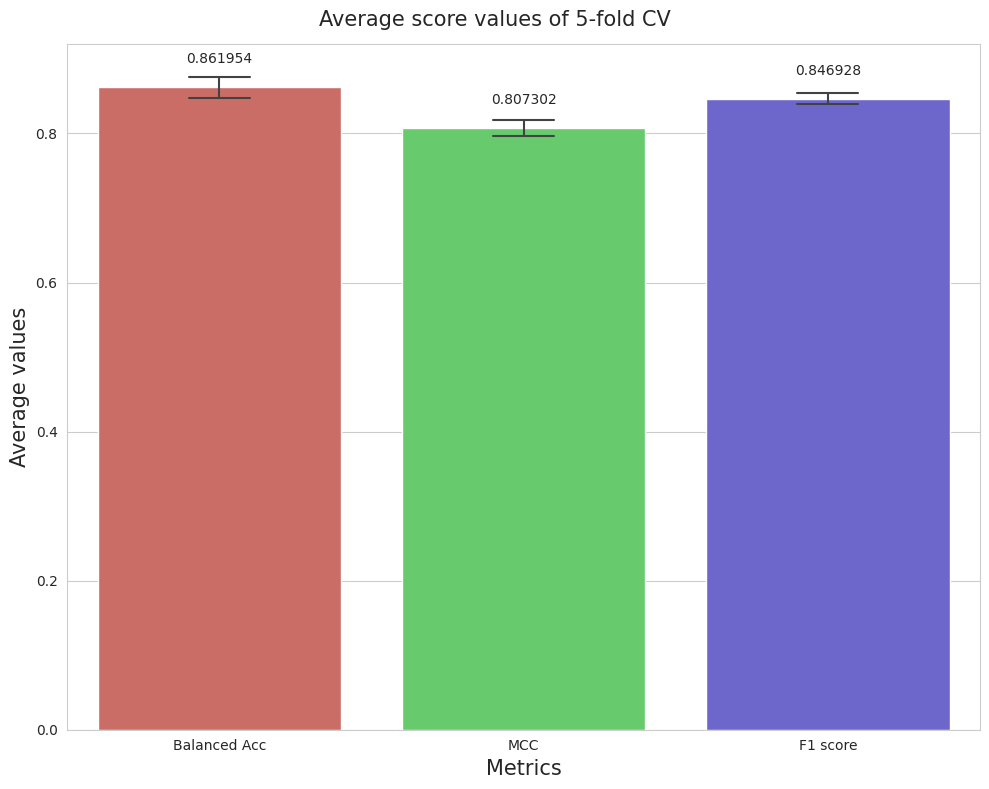

In [27]:
# results_all = [{'train_loss': [0.9627946676576838, 0.5822397846290294, 0.47316639333525123, 0.39256781931309137, 0.33543502599658337, 0.2658478493857033, 0.22722875041996732, 0.15384182246634737, 0.11062711889526862, 0.11631798422005137], 'train_bal_acc': [0.6091899787304201, 0.7695229606994314, 0.8067316727870361, 0.8416224696463664, 0.8756188917531904, 0.9023958027266853, 0.9182873947947481, 0.9444922112201523, 0.9590824453324456, 0.9606721668854021], 'train_mcc': [0.5046721126978047, 0.6956659881691328, 0.7446378628782787, 0.7920744991650878, 0.8293336289326795, 0.8626430571669436, 0.8896701522631675, 0.9277549815086865, 0.9476455117508811, 0.9478035820315381], 'train_f_score': [0.5764503959844526, 0.7475695121590125, 0.7903548963336419, 0.828691154419359, 0.8606508393343952, 0.888321578937471, 0.9095704984092761, 0.9418475459051171, 0.9575628180432906, 0.9579686973158649], 'valid_loss': [0.6238692376543494, 0.5031384326079312, 0.7137555997161305, 0.6586465826805901, 0.47933869765085335, 0.6515201750923606, 0.5889947212794248, 0.597238054170328, 0.7769348428529852, 0.7356662833515335], 'valid_bal_acc': [0.7323448283742404, 0.8003693365458071, 0.7350130588365881, 0.7515209626974333, 0.8162429074193779, 0.7931173891468005, 0.8241127826421945, 0.8116691641691643, 0.7841212708859768, 0.8264171939171938], 'valid_mcc': [0.6542527203496864, 0.7256376960396212, 0.6349606740587214, 0.6848656271500496, 0.7415788773617062, 0.728045761073004, 0.761851475025364, 0.7444149840657195, 0.7031016640431386, 0.7653038862508695], 'valid_f_score': [0.6924230021534177, 0.783871282683441, 0.699959058793528, 0.7387742408302904, 0.7963891694733146, 0.7753176539884288, 0.8108325727017961, 0.8022863996063525, 0.7583216477755697, 0.8134444332136709]}, {'train_loss': [0.22094470042707948, 0.10188348116764032, 0.06340883078176857, 0.08935640290163814, 0.0726748314781991, 0.09337691453915528, 0.038807652789139814, 0.029901945856074558, 0.06315377547349164, 0.05635203638110611], 'train_bal_acc': [0.9298319552179843, 0.969838071266488, 0.9795458626340978, 0.9736874400109696, 0.9706918877690937, 0.9737570232055527, 0.9885131820793587, 0.9913834776334777, 0.9786628934790694, 0.9821724374481725], 'train_mcc': [0.9017634837735359, 0.9583535182914256, 0.9750180133129589, 0.9645811564595826, 0.9620862941927555, 0.9661723744195883, 0.985677443569525, 0.9865841350191097, 0.9719567074864883, 0.9745711663508051], 'train_f_score': [0.9213098211092859, 0.9668753151136336, 0.9801691175977185, 0.9717675983268624, 0.9697754376625564, 0.9728471006168602, 0.988694182403683, 0.9894824845854095, 0.9774755094075767, 0.979915431253171], 'valid_loss': [0.11688099746756694, 0.13029341585934162, 0.11405343343229855, 0.09423722641761689, 0.2148998506805476, 0.12187723641502946, 0.2465956368319252, 0.08732626781634548, 0.1479182612589177, 0.13273587559952454], 'valid_bal_acc': [0.9727839317545199, 0.962784437784438, 0.9659344903462551, 0.9675381318028377, 0.9235903149138442, 0.9643027723910078, 0.9286674926380811, 0.9666677276971396, 0.9470152559858441, 0.9509650480238714], 'valid_mcc': [0.9629681326678633, 0.9448460259261514, 0.9442269517652465, 0.9518112938000175, 0.8965415504251522, 0.9423298323015158, 0.8996505940744579, 0.9529406198563762, 0.924817099778222, 0.9320419251532318], 'valid_f_score': [0.9705558434798365, 0.955983688323209, 0.9550065949809566, 0.9618940477458962, 0.9142959554987553, 0.9544881483345679, 0.917136192528707, 0.9623426361154149, 0.9411880873886017, 0.9460917660315218]}, {'train_loss': [0.06762893128753229, 0.05494115112849292, 0.02613393446389476, 0.10907816171461224, 0.027126011442519752, 0.043210910971966394], 'train_bal_acc': [0.9789494839311016, 0.9817977406580349, 0.9928306538233007, 0.9735875603155015, 0.9920097875980228, 0.9873876776817951], 'train_mcc': [0.9722958314298159, 0.9780428647127299, 0.9901875779121483, 0.9639712121590098, 0.9891511712688287, 0.981923693640073], 'train_f_score': [0.9782620150489221, 0.9820108094492473, 0.9922769287690967, 0.9716387626380323, 0.9915904550206172, 0.9856016278012594], 'valid_loss': [0.020652413871550167, 0.021704104907043716, 0.0655968176707735, 0.0749868821927949, 0.030752411125885212, 0.04114580967956606], 'valid_bal_acc': [0.9935480859010272, 0.9965569561157795, 0.9811367880485529, 0.9803335879806471, 0.9898832866479924, 0.9850000000000001], 'valid_mcc': [0.9906118212571187, 0.9941054386764212, 0.972342217450547, 0.9732176264882949, 0.9880664391994429, 0.9802213955805629], 'valid_f_score': [0.9926090193459278, 0.9954433336717985, 0.9782121886896251, 0.9787484681681539, 0.9906909107003827, 0.9841428250569593]}, {'train_loss': [0.13723791189766096, 0.03477925102411331, 0.046606388449457456, 0.03756942905281047, 0.0335527715527432, 0.029309230205185218, 0.035920373059906634], 'train_bal_acc': [0.95923286272551, 0.9891662749015692, 0.9876907936834404, 0.9888941777177072, 0.9896807359307358, 0.9893433812919108, 0.9895025358628295], 'train_mcc': [0.950269607163429, 0.9852372440662457, 0.9834717907452831, 0.9855626472448141, 0.9873339127671282, 0.986428306927844, 0.9851316147449033], 'train_f_score': [0.959927854547292, 0.9882443428441481, 0.9868846505498463, 0.9884224203671972, 0.9898371301826077, 0.9891666582174231, 0.9881729379713178], 'valid_loss': [0.07403050231582978, 0.013959448302664575, 0.05595329633968718, 0.03395577842499787, 0.07638179524185355, 0.04103120454986792, 0.07244019100428833], 'valid_bal_acc': [0.9814141414141413, 0.9932539682539682, 0.9808492487904253, 0.9883356676003734, 0.9764043146396089, 0.9902334267040148, 0.9792549444020032], 'valid_mcc': [0.9767408026920523, 0.992963806982357, 0.9757883123500872, 0.9861004324562993, 0.9597633221291392, 0.9873712122100303, 0.9692021411244428], 'valid_f_score': [0.9815061486922261, 0.9942960918725239, 0.9805266200973134, 0.9889372644376275, 0.968391074026222, 0.9898412176551972, 0.9751242006462624]}, {'train_loss': [0.03633734955099713, 0.04700147283785876, 0.042516198410981705, 0.04194321836225486, 0.021643497164297837, 0.0040473770212456125, 0.051363232196208364, 0.07290867624739322, 0.06098386895802618, 0.026948013557664713], 'train_bal_acc': [0.9890944145723557, 0.9842481374834317, 0.9894665873342343, 0.9844164944532592, 0.9934261071852982, 0.9990079365079365, 0.9872722498090146, 0.9778680388239214, 0.9833868827251178, 0.9915120418796891], 'train_mcc': [0.9844102122022608, 0.9801894534300869, 0.9846994908745242, 0.977607296759242, 0.9910342756678618, 0.9985404356434461, 0.9825923782314168, 0.9701661092138624, 0.97759185830708, 0.9881811602389928], 'train_f_score': [0.9876980502944451, 0.9843925563148287, 0.9878980055494777, 0.98227107473525, 0.9929781902935175, 0.9988662950042937, 0.9861424566542984, 0.9760796425249614, 0.9823061662905994, 0.990579480171223], 'valid_loss': [0.014132972396242515, 0.03458607899494168, 0.09961753474164974, 0.011430984362959862, 0.031713323790908736, 0.004898638243342729, 0.11650880761718486, 0.044840588953400796, 0.07334855611449764, 0.036708449968821645], 'valid_bal_acc': [0.9973529411764707, 0.9932698837110602, 0.9692201426024956, 0.9969815805109924, 0.9884708428826076, 0.998235294117647, 0.964940794499618, 0.9873919870978694, 0.9792693744164334, 0.9896914523385112], 'valid_mcc': [0.9964520962755844, 0.9895101948698816, 0.9662944753411852, 0.995417112367331, 0.9861904776820731, 0.9977223668307351, 0.9557715511308457, 0.9836628181802924, 0.9729234792318794, 0.9844905563411527], 'valid_f_score': [0.9972176977611762, 0.991839540486734, 0.97322148219663, 0.996340600719926, 0.9889312676942436, 0.9981700714576102, 0.9647638778947112, 0.9870576999279791, 0.978813605073408, 0.9879748123368364]}]
# plot cross validation's average scores on the validation splits
import pandas as pd
# mean_bal_acc = np.mean([max(results_all[i]['valid_bal_acc']) for i in range(len(results_all))])
# mean_mcc = np.mean([max(results_all[i]['valid_mcc']) for i in range(len(results_all))])
# mean_f_score = np.mean([max(results_all[i]['valid_f_score']) for i in range(len(results_all))])
# mean_scores = [mean_bal_acc, mean_mcc, mean_f_score]
# score_names = ['Balanced Acc', 'MCC', 'F1 score']
my_dict = {'Balanced Acc': [results_all[i]['valid_bal_acc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))], 
           'MCC': [results_all[i]['valid_mcc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))], 
           'F1 score': [results_all[i]['valid_f_score'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))]}

my_df = pd.DataFrame(my_dict)
print(my_df)
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(data= my_df, estimator=np.mean, color='blue', palette='hls', errorbar="sd", capsize=.2, errwidth=1.5)
ax.bar_label(ax.containers[0], padding=15)

plt.xlabel('Metrics', fontsize=15)
plt.ylabel(f'Average values', fontsize=15)

plt.suptitle(f'Average score values of 5-fold CV', fontsize=15)
plt.savefig(f'/kaggle/working/efficientNet_cv_scores.png')
plt.show()

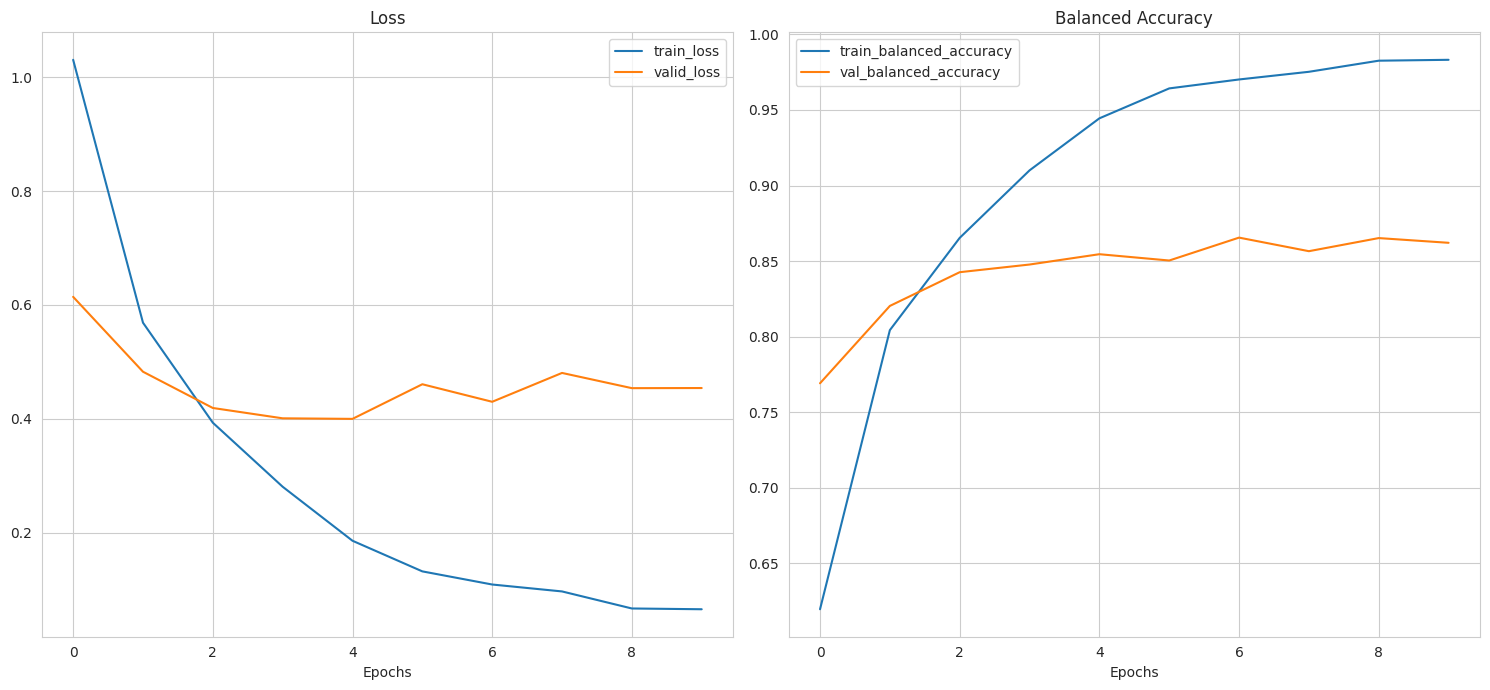

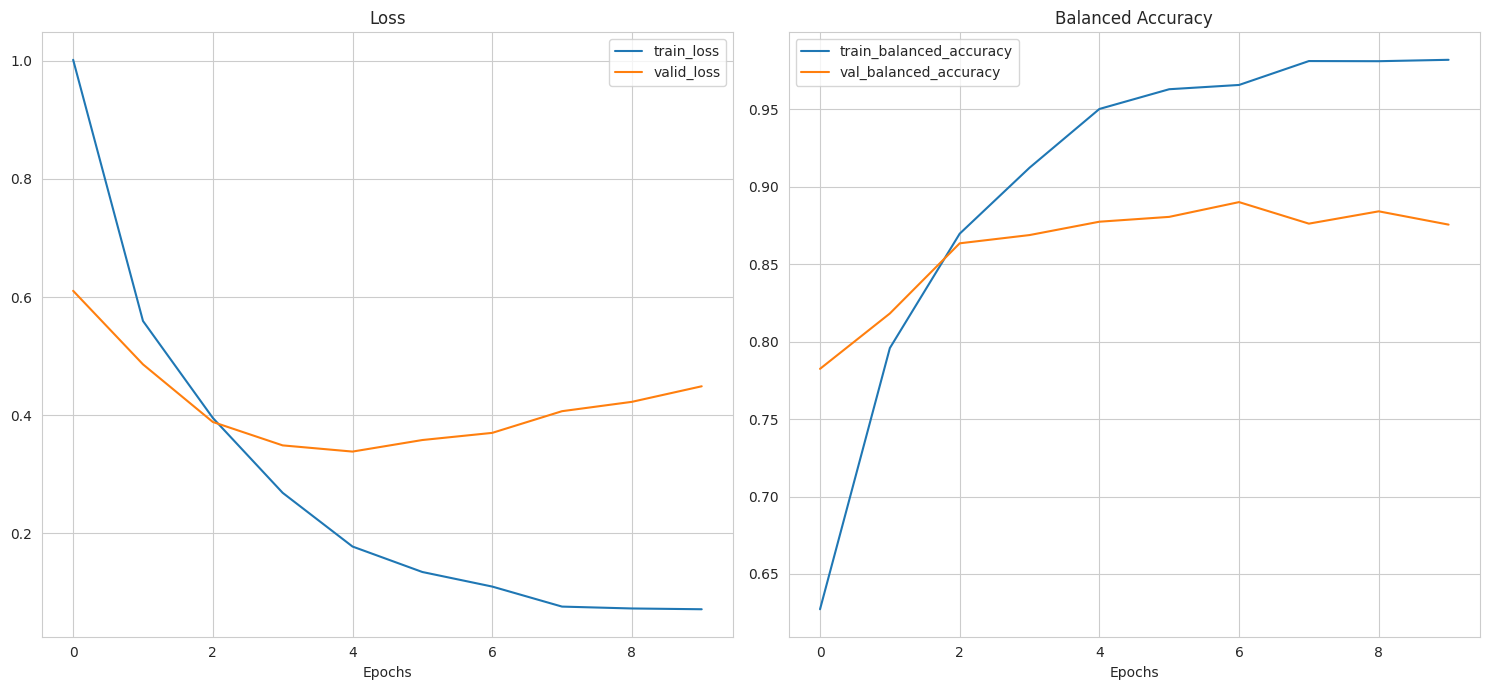

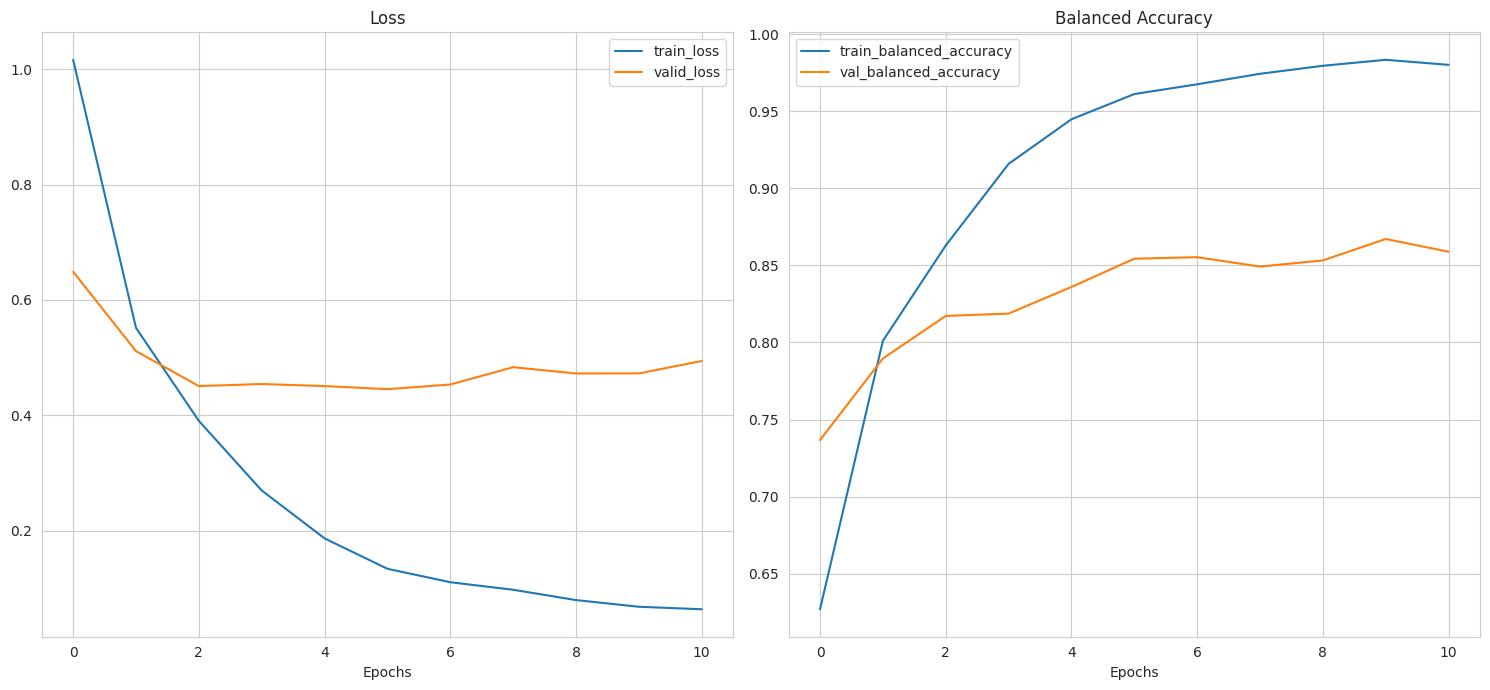

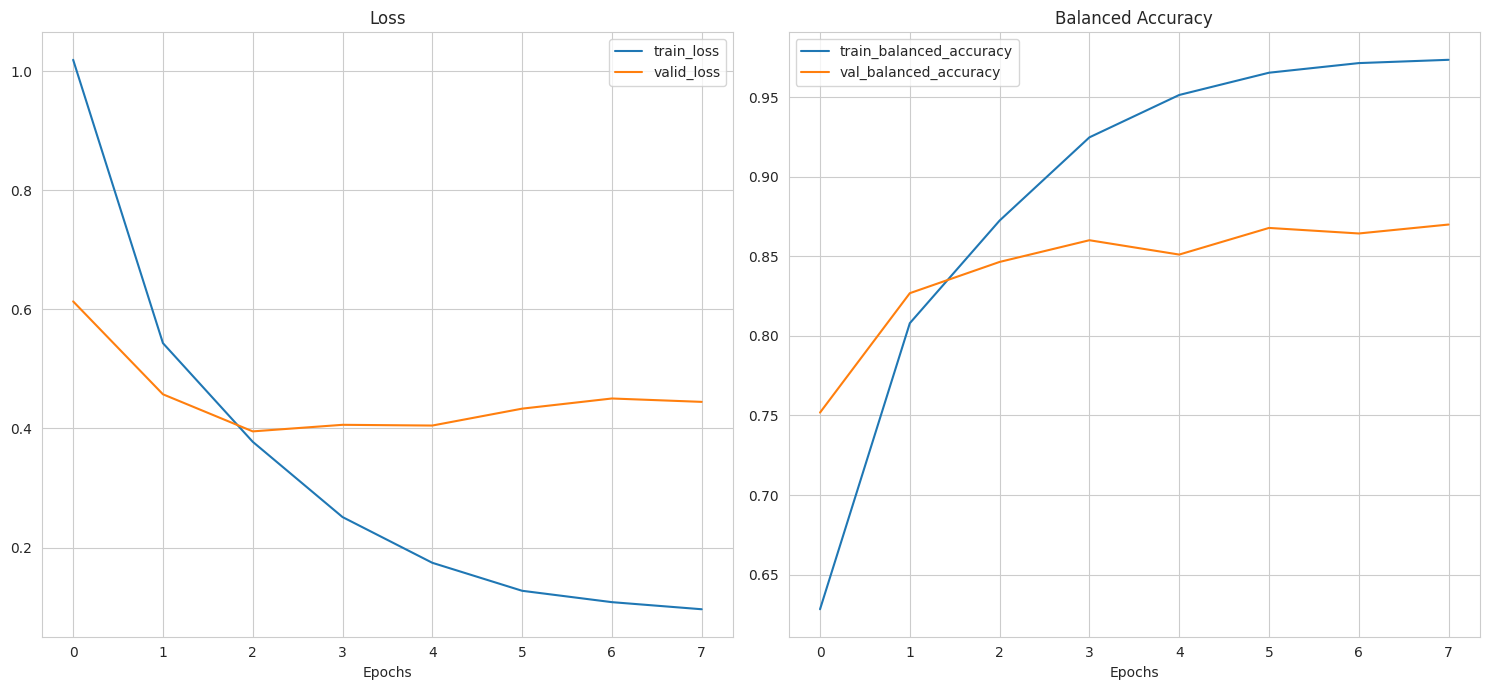

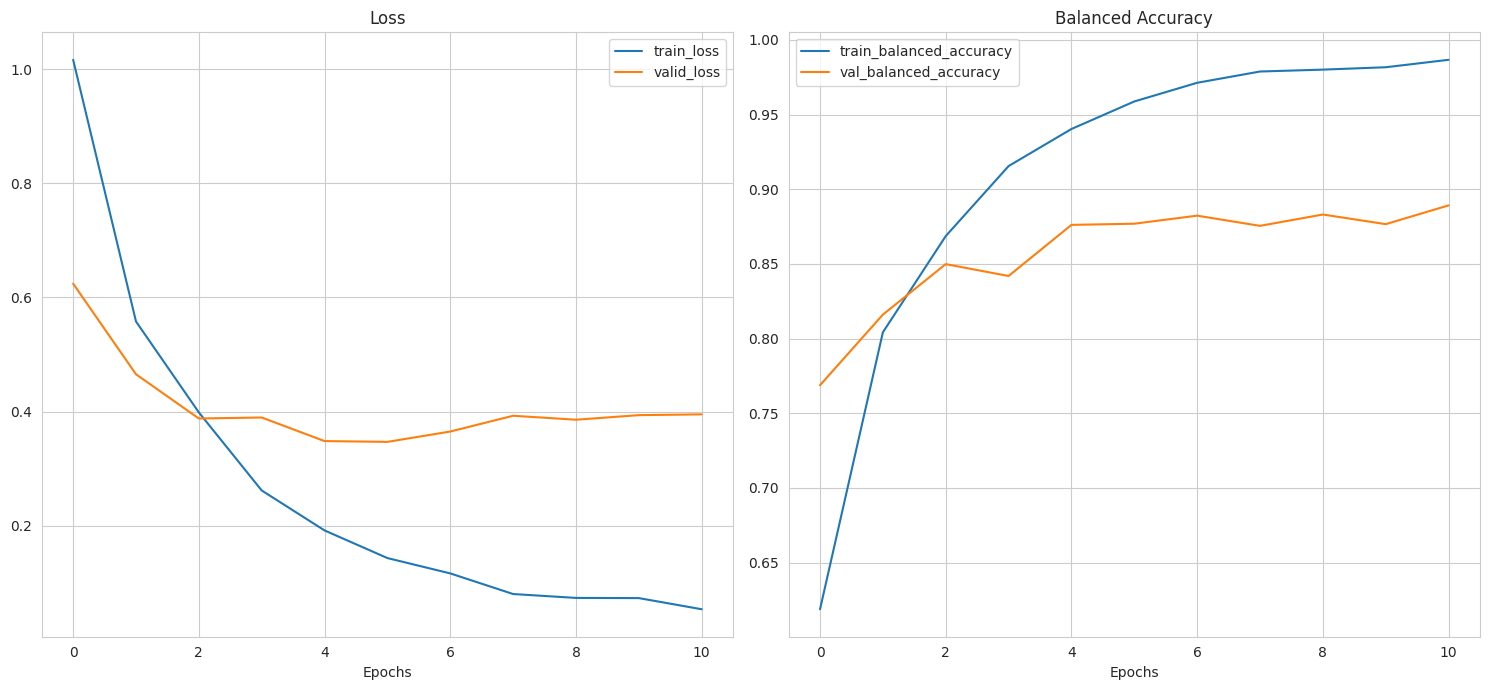

In [28]:
# Plot the loss curves of our model
for i in range(len(results_all)):
    helper_functions.plot_loss_curves(results_all[i])
    plt.savefig(f'/kaggle/working/efficientNet_loss_curves_split_{i}.png')

# Final model

Train a final model and evaluate it on the held out test set

Start Training of final model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0245 | train_bal_acc: 0.6184 | train_mcc: 0.4969 | valid_loss: 0.6125 | valid_bal_acc: 0.7789 | valid_mcc: 0.7059
Epoch: 2 | train_loss: 0.5585 | train_bal_acc: 0.8031 | train_mcc: 0.7145 | valid_loss: 0.4767 | valid_bal_acc: 0.8179 | valid_mcc: 0.7625
Epoch: 3 | train_loss: 0.3935 | train_bal_acc: 0.8668 | train_mcc: 0.8024 | valid_loss: 0.3982 | valid_bal_acc: 0.8394 | valid_mcc: 0.7869
Epoch: 4 | train_loss: 0.2773 | train_bal_acc: 0.9133 | train_mcc: 0.8664 | valid_loss: 0.3859 | valid_bal_acc: 0.8545 | valid_mcc: 0.7992
Epoch: 5 | train_loss: 0.1881 | train_bal_acc: 0.9459 | train_mcc: 0.9137 | valid_loss: 0.3620 | valid_bal_acc: 0.8765 | valid_mcc: 0.8274
Epoch: 6 | train_loss: 0.1474 | train_bal_acc: 0.9625 | train_mcc: 0.9362 | valid_loss: 0.3522 | valid_bal_acc: 0.8782 | valid_mcc: 0.8389
Epoch: 7 | train_loss: 0.1116 | train_bal_acc: 0.9712 | train_mcc: 0.9525 | valid_loss: 0.3693 | valid_bal_acc: 0.8789 | valid_mcc: 0.8404
Epoch: 8 | train_loss: 0.08

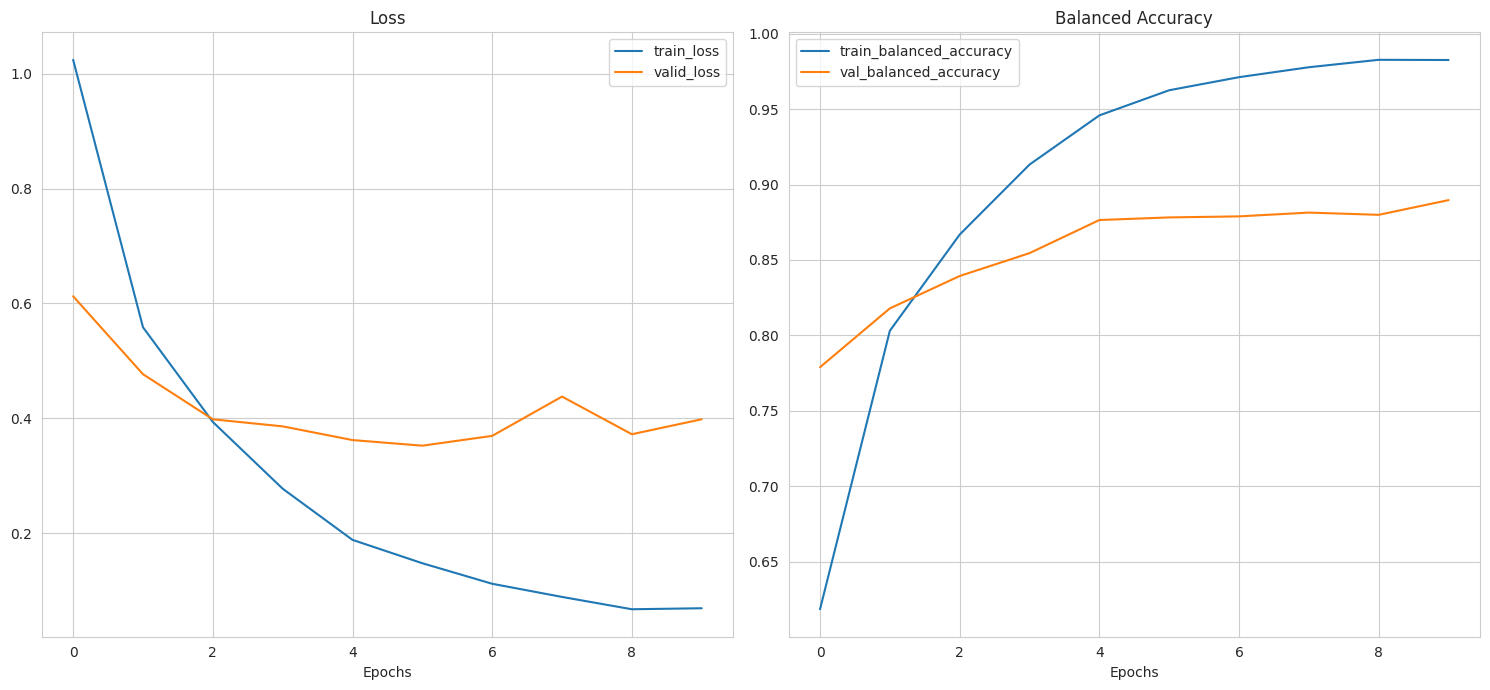

In [29]:
# train final model on the reduced set with a split 85-15 train-val
reduced_dataset = train_subset
train_indices, val_indices = train_test_split(train_idx, test_size=0.20, stratify=train_targets, random_state=42)  # set seed to ensure reproducibility
                                              
train_subset = Subset(train_dataset, train_indices)
train_targets=[train_dataset.targets[i] for i in train_indices]
                                              
val_subset = Subset(train_dataset, val_indices)
val_targets=[train_dataset.targets[i] for i in val_indices]
                                              
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
                                              
                                              
start_time = timer()

# Load the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
num_ftrs = model.classifier[1].in_features

model.classifier[1] = nn.Linear(num_ftrs, 5).to(device)

# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

print('Start Training of final model')
results, final_model = engine.train_with_early_stopping(model=model,
                                              train_dataloader=train_loader,
                                              valid_dataloader=val_loader,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              epochs=10,
                                              device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds\n")

MODEL_SAVE_PATH = os.path.join('/kaggle/working/', '01_efficientnet_final_model.pth')
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=final_model.state_dict(), f=MODEL_SAVE_PATH)
                                              
helper_functions.plot_loss_curves(results)
plt.savefig(f'/kaggle/working/training_curves_efficientnet_final_model.png')

## Test final model on the held out test set

In [30]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
import torch.nn.functional as F

model=final_model


model.eval()


with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    all_test_pred_prob=[]
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y) in enumerate(test_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = loaded_model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_pred_prob = torch.softmax(test_pred_logits.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())
        all_test_pred_prob.extend(test_pred_prob.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    



Test loss: 1.6634329474249552 | Test bal acc 0.15688159385833803 | Test mcc -0.05791436733212532 | Test_f_score 0.1408743958059455



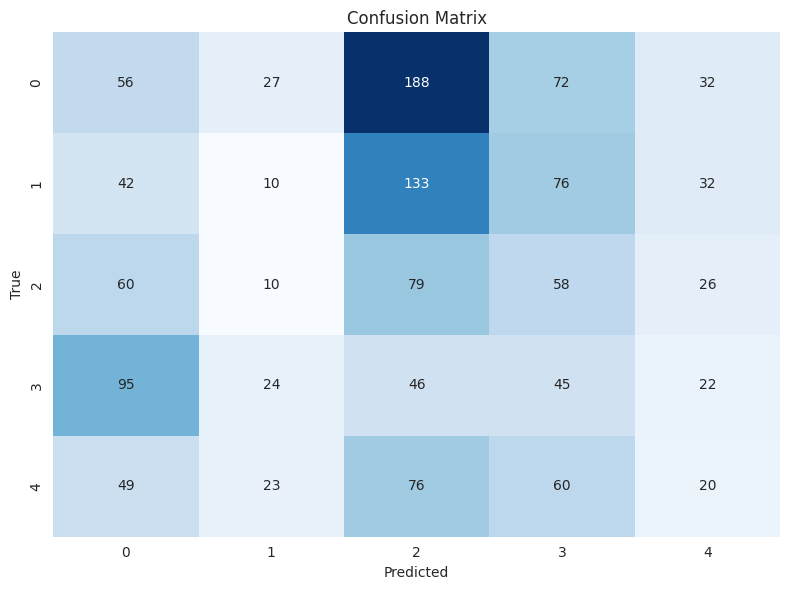

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'/kaggle/working/efficientNet_final_model_cm.png', dpi=300)
plt.show()


In [32]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.19      0.15      0.17       375
           1       0.11      0.03      0.05       293
           2       0.15      0.34      0.21       233
           3       0.14      0.19      0.17       232
           4       0.15      0.09      0.11       228

    accuracy                           0.15      1361
   macro avg       0.15      0.16      0.14      1361
weighted avg       0.15      0.15      0.14      1361



# Train final model with data augmentations on the train set

In [33]:
# Define train and val transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
# Reload training data with augmentations
#train_indices, val_indices = train_test_split(train_idx, test_size=0.15, stratify=train_targets, random_state=42)

train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
val_dataset = ImageFolder(DATA_DIR, transform=val_transforms)

train_subset = Subset(train_dataset, train_indices)
train_targets=[train_dataset.targets[i] for i in train_indices]
                                              
val_subset = Subset(val_dataset, val_indices)
val_targets=[train_dataset.targets[i] for i in val_indices]
                                              
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

Start Training of final model with train data augmentations


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4181 | train_bal_acc: 0.8604 | train_mcc: 0.7968 | valid_loss: 0.3447 | valid_bal_acc: 0.8713 | valid_mcc: 0.8173
Epoch: 2 | train_loss: 0.2982 | train_bal_acc: 0.8967 | train_mcc: 0.8464 | valid_loss: 0.3308 | valid_bal_acc: 0.8768 | valid_mcc: 0.8289
Epoch: 3 | train_loss: 0.2637 | train_bal_acc: 0.9111 | train_mcc: 0.8680 | valid_loss: 0.3285 | valid_bal_acc: 0.8791 | valid_mcc: 0.8341
Epoch: 4 | train_loss: 0.2311 | train_bal_acc: 0.9219 | train_mcc: 0.8833 | valid_loss: 0.2879 | valid_bal_acc: 0.8929 | valid_mcc: 0.8502
Epoch: 5 | train_loss: 0.2155 | train_bal_acc: 0.9326 | train_mcc: 0.8928 | valid_loss: 0.3147 | valid_bal_acc: 0.8889 | valid_mcc: 0.8419
Epoch: 6 | train_loss: 0.1675 | train_bal_acc: 0.9467 | train_mcc: 0.9149 | valid_loss: 0.2965 | valid_bal_acc: 0.8976 | valid_mcc: 0.8577
Epoch: 7 | train_loss: 0.1658 | train_bal_acc: 0.9455 | train_mcc: 0.9130 | valid_loss: 0.3088 | valid_bal_acc: 0.9017 | valid_mcc: 0.8603
Epoch: 8 | train_loss: 0.14

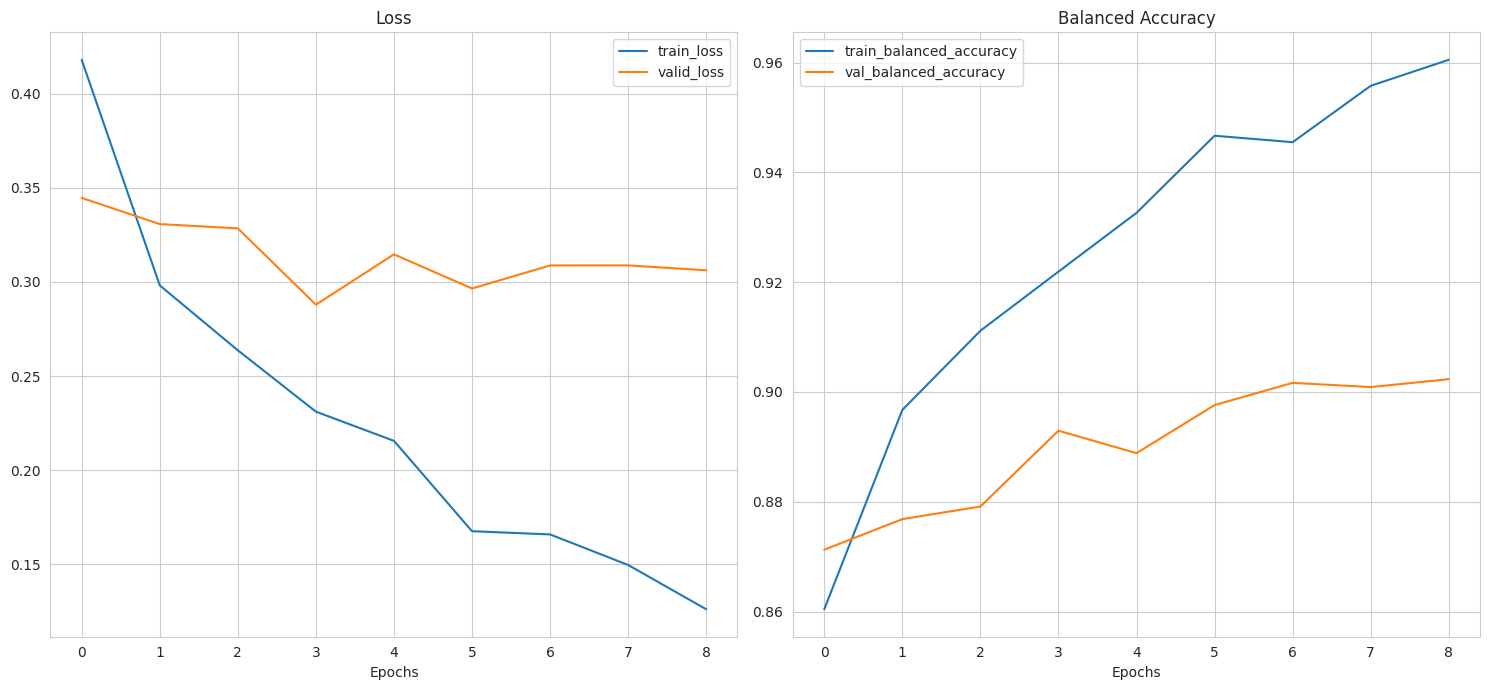

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()


model_2aug = create_efficientnetb0_custom(num_classes=num_classes).to(device)
## if we want to continue training our final model with the augmented training set then: 
# model_2aug=final_model

# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

print('Start Training of final model with train data augmentations')
results_aug, final_model_aug = engine.train_with_early_stopping(model=model,
                                                          train_dataloader=train_loader,
                                                          valid_dataloader=val_loader,
                                                          optimizer=optimizer,
                                                          loss_fn=loss_fn,
                                                          epochs=20,
                                                          device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds\n")

MODEL_SAVE_PATH = os.path.join('/kaggle/working/', '02_EfficientNEtb0_final_model_augment.pth')
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=final_model_aug.state_dict(), f=MODEL_SAVE_PATH)
                                              
helper_functions.plot_loss_curves(results_aug)
plt.savefig(f'/kaggle/working/training_curves_EfficientNEtb0_final_model_augment.png')

# Test final model trained with data augmentations on the held out test set

In [36]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

model=final_model_aug

model.eval()
with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y) in enumerate(test_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    

Test loss: 0.28320183552974876 | Test bal acc 0.9010478023268718 | Test mcc 0.8623562182276735 | Test_f_score 0.8889368832768466



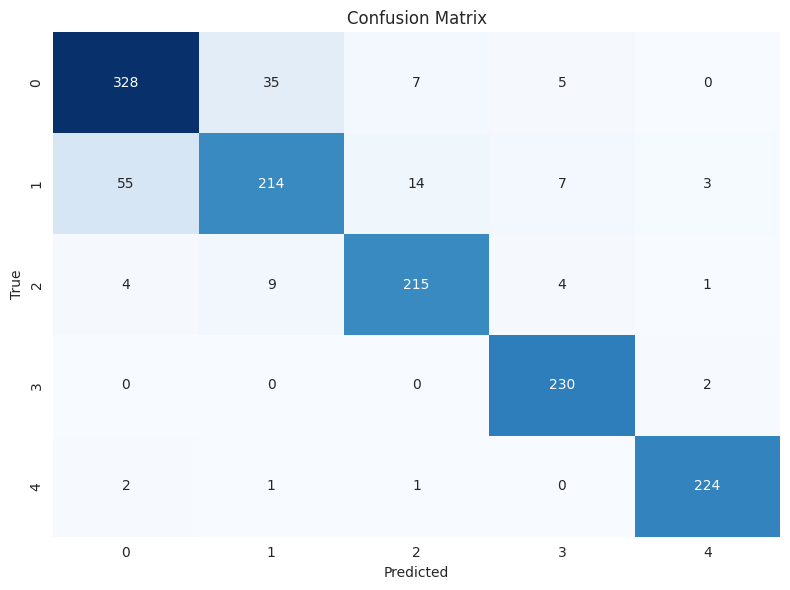

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'/kaggle/working/EfficietnNetb0_final_model_aug_cm.png', dpi=300)
plt.show()

In [38]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       375
           1       0.83      0.73      0.78       293
           2       0.91      0.92      0.91       233
           3       0.93      0.99      0.96       232
           4       0.97      0.98      0.98       228

    accuracy                           0.89      1361
   macro avg       0.90      0.90      0.90      1361
weighted avg       0.89      0.89      0.89      1361



# Load saved model from working directory

In [39]:
# Define your model
loaded_model = custom_efficientnet 

# Define the path to the weights file
weights_file_path = MODEL_SAVE_PATH

# Check if the weights file exists and load them while mapping to CPU
if os.path.exists(weights_file_path):
    state_dict = torch.load(weights_file_path, map_location=torch.device('cpu'))
    custom_efficientnet.load_state_dict(state_dict)
    print("Weights loaded successfully.")
else:
    print(f"Weights file not found at {weights_file_path}. Model initialized with default weights.")


Weights loaded successfully.


# Visualizing predictions


## Create a function for plotting images and predictions


In [40]:
# model=loaded_model

In [41]:
# 1. Take in a trained model, class names, dataset, image size, a transform, and target device
def pred_and_plot_image(model: torch.nn.Module,
                        dataset: torch.utils.data.Dataset,  # Assuming a custom dataset class
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: transforms.Compose = None,
                        number_of_images=5,
                        device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    # 2. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = test_transforms

    ### Predict on images from the dataset ### 

    # 3. Make sure the model is on the target device
    model.to(device)

    # 4. Turn on model evaluation mode
    model.eval()

    # 5. Iterate through the dataset and make predictions
    for i in range(number_of_images):
        image, label = dataset[i]  # Assuming your dataset returns (image, label) pairs

        # 6. Send the image tensor to the target device
        image = image.to(device)

        # 7. Make a prediction on the image
        with torch.no_grad():
            target_image_pred = model(image.unsqueeze(0))  # Add a batch dimension

        # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # 9. Convert prediction probabilities -> prediction label
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1).item()

        # 10. Plot the image tensor with predicted label and probability
        plt.figure()
        plt.imshow(image.cpu().numpy().squeeze().transpose(1, 2, 0))  # Convert tensor to NumPy array
        plt.title(f"True: {class_names[label]}, Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
        plt.axis(False)


In [42]:
# Create list with class names
class_names=["H1","H2","H3","H5","H6"]

## Plot some predictions

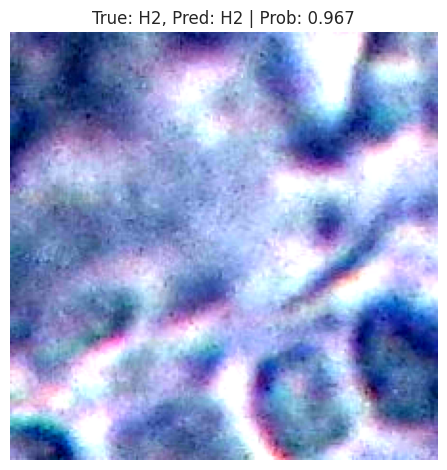

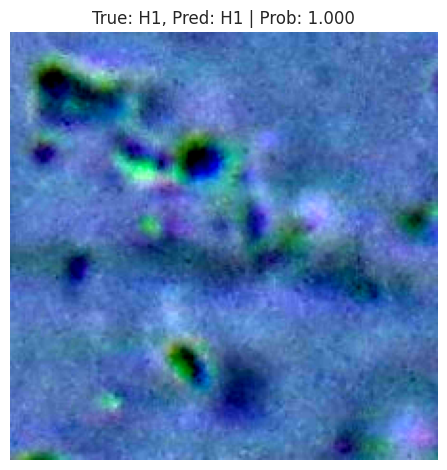

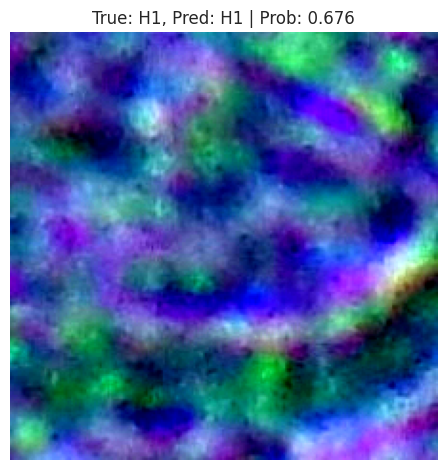

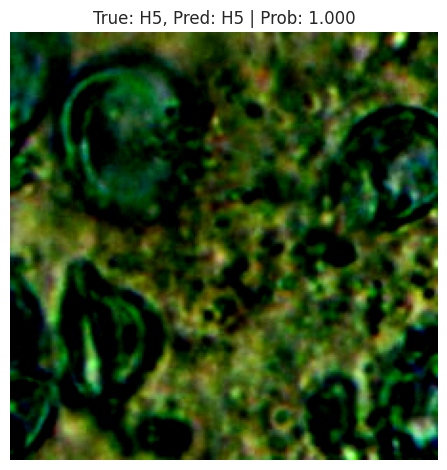

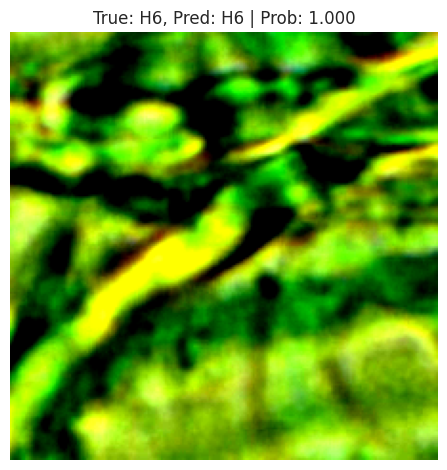

In [43]:
# Plot some predictions
pred_and_plot_image(model, test_subset, class_names, image_size=(224, 224))


## Plot some wrong predictions

In [44]:
# Find the images of the test_subset that have been classifies wrong
wrong_indices = [i for i in range(len(all_true_labels)) if all_true_labels[i] != all_predictions[i]]
wrong_set=[test_subset[i] for i in wrong_indices]


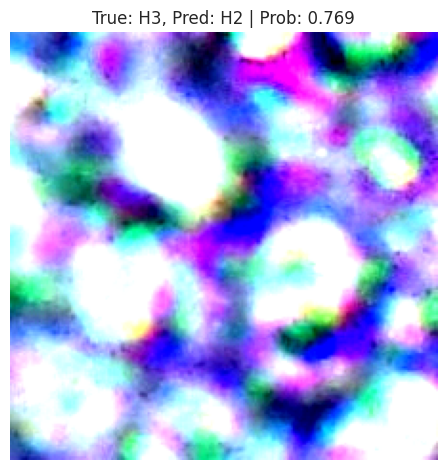

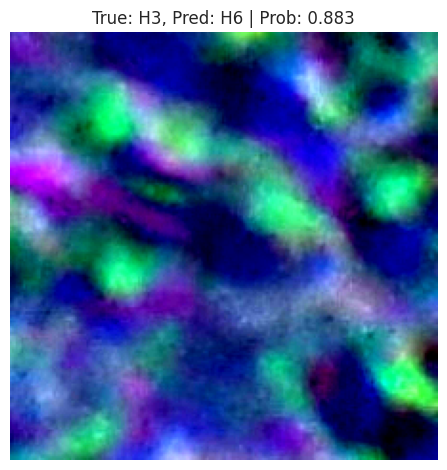

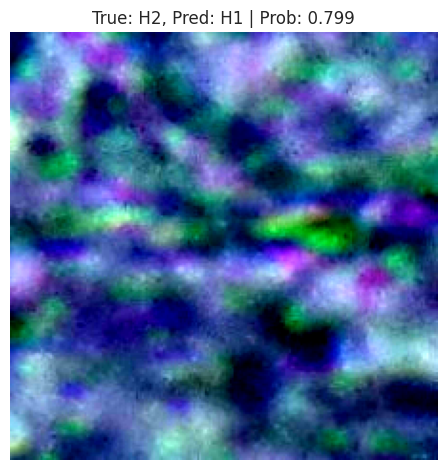

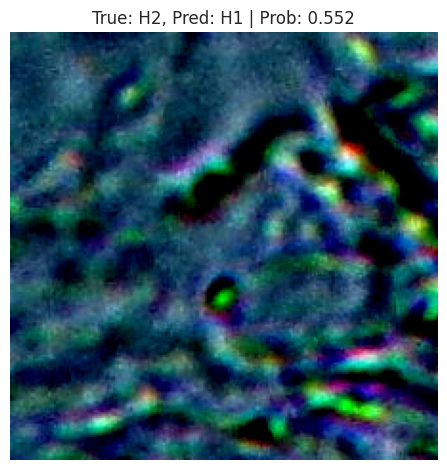

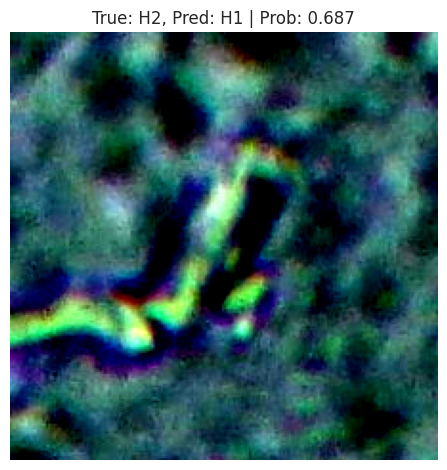

In [45]:
# Plot wrongly classified images with probabilies
pred_and_plot_image(model, wrong_set, class_names, image_size=(224, 224))

# Model Explainability using GradCam

In [46]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=8d924ad60643a4d3452576778448284771e787e6769971bc5a959c3e5889d14c
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [47]:
from pytorch_grad_cam import GradCAM
from PIL import Image

from torchvision.transforms.functional import to_tensor
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import cv2 

In [48]:
model=loaded_model

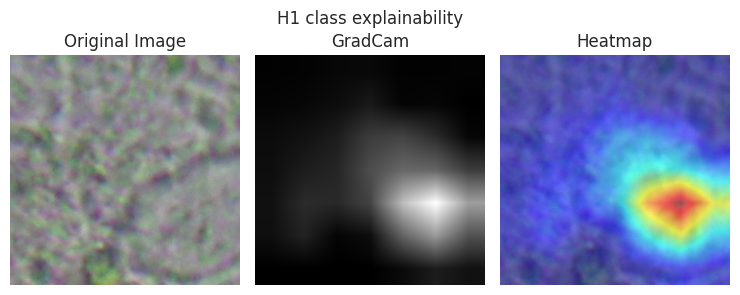

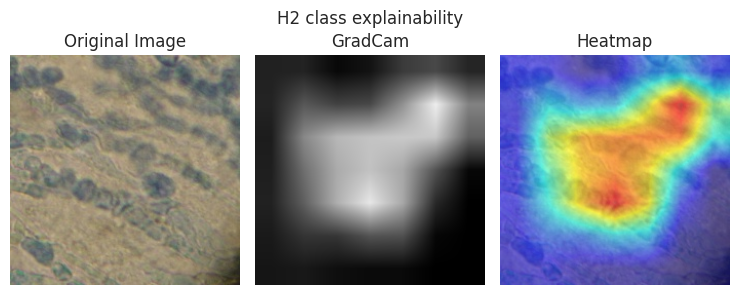

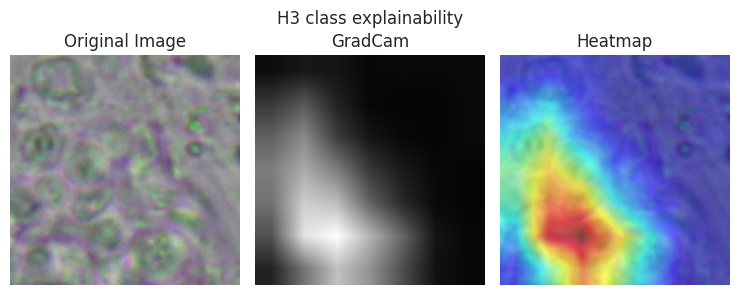

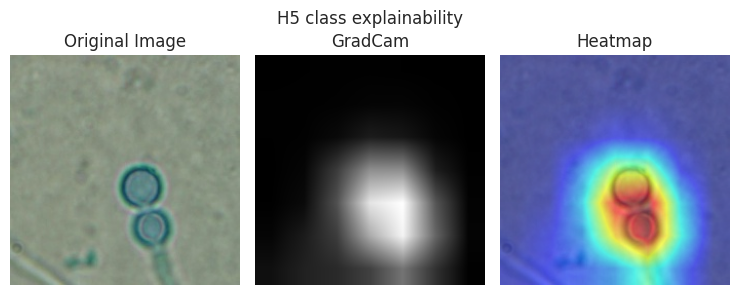

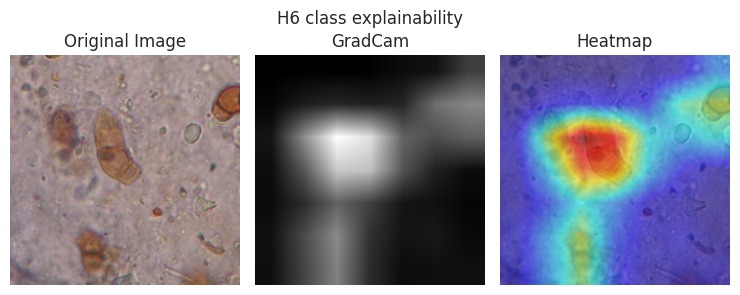

In [49]:
image_filenames = ['/kaggle/input/fungi-all/H1/H1_100a_1.jpg.jpg',
                   '/kaggle/input/fungi-all/H2/H2_103b_2.jpg.jpg',
                   '/kaggle/input/fungi-all/H3/H3_10a_3.jpg.jpg',
                   '/kaggle/input/fungi-all/H5/H5_103a_2.jpg.jpg',
                   '/kaggle/input/fungi-all/H6/H6_12a_3.jpg.jpg'
                  ]

target_layer = model.features[-1] # this is the target layer that we want grad cam to use its feature map and generate the Grad-CAM heatmaps

def show(imgs, title):
    sub_plot_titles = ['Original Image', 'GradCam', 'Heatmap']
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    plt.rcParams["figure.figsize"] = [7.50, 3]
    fig, axs = plt.subplots(1, len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set_title(sub_plot_titles[i])
        axs[0, i].grid(False)
        axs[0, i].axis('off')
        
    fig.suptitle(title)
    plt.grid(False)
    plt.axis('off')
    plt.show()
    
    
def reshape_transform(tensor, height=14, width=14):
    # This function transforms the tensors of Vit to use them with Grad Cam similarly as the results of CNN models
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
    
    
def visualize_gradcam(model, layer, device, filenames, vit=False):
    for idx, class_name in enumerate(['H1', 'H2', 'H3', 'H5', 'H6']):
        model.eval()

        img = np.array(Image.open(filenames[idx]))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255
        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        if device == 'cuda':
            use_cuda = True
        else:
            use_cuda = False

        # The target for the CAM is the class of each image.
        # As usual for classication, the target is the logit output
        # before softmax, for that category.
        target_layers = [layer]
        targets = [ClassifierOutputTarget(idx)] 
        
        if vit:
            with GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda, reshape_transform=reshape_transform) as cam:
                grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets, aug_smooth=True)
                cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        else:
            with GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda) as cam:
                grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets, aug_smooth=True)
                cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

        cam = np.uint8(255*grayscale_cams[0, :])
        cam = cv2.merge([cam, cam, cam])
        # images = np.hstack((np.uint8(255*img), cam , cam_image))
        images = [np.uint8(255*img), cam , cam_image]
        show(images, f'{class_name} class explainability')
        # Image.fromarray(images)
        
visualize_gradcam(model, target_layer, device, image_filenames)